<h1> Image Classification using Data Augmentation on VGG-like architecture</h1>

Image Classification helps us in taking important decisions. But the data is not always availaible hence the model we learn dont learn feature efficiently and are prone to over-fitting. Hence it is need of the hour to apply techniques such as Data Augmentation that increases the amount of data and allow model to learn variations that were not employed before. VGG-like architecture is used to use the concept of Data Augmentation



In [18]:
# necessary imports
import tensorflow as tf
from sklearn.datasets import load_files
import numpy as np
import os
import cv2
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
import collections
from keras.layers import BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD, RMSprop
import keras
from keras.layers import Conv2D, Dense, MaxPool2D, Flatten, Dropout
from keras.models import Sequential
import os
import sys
import datetime
import glob as glob
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import SGD
import tensorflow
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, f1_score
from skimage import feature
from skimage import exposure
from tqdm.notebook import tqdm
from sklearn.svm import LinearSVC
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
from google.colab import files
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
%matplotlib inline

<h2> Load Dataset </h2>
Here we will download the Dataset of Natural Scene from kaggel intel-image-classification and unzip it in local colab directory <br><br>


In [ ]:
#Uploading kaggle.json file
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aamna27","key":"9944f09a800fd209ebde42468fb6f834"}'}

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d puneet6060/intel-image-classification

 97% 337M/346M [00:01<00:00, 241MB/s]
100% 346M/346M [00:01<00:00, 237MB/s]


In [ ]:
!unzip intel-image-classification.zip -d Dataset
!rm -rf /content/intel-image-classification.zip

In [ ]:
!rm -rf /content/Dataset/seg_pred
!unzip Test_data.zip -d Dataset

In [ ]:
train_dir = 'Dataset/seg_train/seg_train'
validate_dir = 'Dataset/seg_test/seg_test'
test_dir = 'Dataset/seg_pred/seg_pred'

batch_size = 32
nb_classes = len(glob.glob(train_dir + '/*'))

# get number of images in training directory
nb_train_samples = 0
for r, dirs, files in os.walk(train_dir):
    for dr in dirs:
        nb_train_samples += len(glob.glob(os.path.join(r, dr + "/*")))
# get number of images in validation directory
nb_validate_samples = 0
for r, dirs, files in os.walk(validate_dir):
    for dr in dirs:
        nb_validate_samples += len(glob.glob(os.path.join(r, dr + "/*")))

nb_test_samples = 0
for r, dirs, files in os.walk(test_dir):
    for dr in dirs:
        nb_test_samples += len(glob.glob(os.path.join(r, dr + "/*")))

Making dictionary to store results of experiments

In [9]:

all_acc_dict = collections.OrderedDict()
accdict = {}

<h2> Data Augmentation </h2>
Data preparation is almost always required when working with any data analysis, machine learning, neural network or deep learning models. It becomes even more important to augment data in the case of image recognition. Keras provides the ImageDataGenerator class that defines the configuration for image data preparation and augmentation

In [11]:

nb_epochs = 20
batch_size = 32
# data pre-processing for training
train_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

# data pre-processing for validation
validate_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)
# data pre-processing for validation
test_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    # zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [13]:
# generate and store training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (32, 32),
    batch_size = batch_size)

# generate and store validation data
validate_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size = (32, 32),
    batch_size = batch_size)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (32, 32),
    batch_size = batch_size)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 7301 images belonging to 6 classes.


<h2> VGG-Like Architecture </h2>
Architecture build on VGG style is being used here. Since original architecture was very complex, few layers have been removed based on problem at hand. Instead of 224*224*3, input shape of 32*32*3 has been used.

In [15]:
def VGG16model(OPTIMIZER, DECAY, MOMEMTUM, LEARN_RATE, EPOCHS, INPUT_SHAPE_WIDTH = 32, 
               INPUT_SHAPE_HEIGHT = 32, INPUT_SHAPE_CHANNEL = 3):
  model = Sequential()
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", 
                  input_shape=(INPUT_SHAPE_WIDTH,INPUT_SHAPE_HEIGHT,INPUT_SHAPE_CHANNEL),))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=6, activation="softmax"))

  if OPTIMIZER == "Adam":
    print(OPTIMIZER)
    LEARN_RATE = 0.001/EPOCHS  #in case you want to manually set fix lr
    adam = Adam(lr=LEARN_RATE)
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=adam)

  if OPTIMIZER == "SGD":
    print(OPTIMIZER)
    LEARN_RATE = 0.001/EPOCHS  #in case you want to manually set fix lr
    sgd = SGD(lr=LEARN_RATE) 
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=sgd)

  if OPTIMIZER == "RMS":
    print(OPTIMIZER)
    LEARN_RATE = 0.001/EPOCHS  #in case you want to manually set fix lr
    rms = RMSprop(lr=LEARN_RATE)
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=rms)
  return (model)

In [ ]:

vgg_model_pic = VGG16model("Adam", DECAY= 1e-7, MOMEMTUM = 0.9, LEARN_RATE =0.001, EPOCHS =75)
plot_model(vgg_model_pic, to_file='Results/VGG-like-model.png', show_shapes=True)

<h2> Compile and Train the Model </h2>
Using different choices of optimizers, the model is being trained. **Early Stopping** is being used to tackle number of epochs. Each time a better validation accuracy is achieved the model weights are updated in the directory.


In [14]:

es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('CheckPoints/VGG-like-Aug-model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

def training(BATCH_SIZE, EPOCHS, OPTIMIZER, LEARN_RATE, DECAY = 0, MOMEMTUM = 0 ):
  # accdict = {}
  vgg_model = VGG16model(OPTIMIZER, DECAY, MOMEMTUM, LEARN_RATE, EPOCHS)
  H = vgg_model.fit_generator(
    train_generator,
    epochs = EPOCHS,
    validation_data = validate_generator,
    callbacks=[es,mc])
  trainacc = H.history['accuracy']
  valacc = H.history['val_accuracy']
  trainloss = H.history['loss']
  valloss = H.history['val_loss']
  score = vgg_model.evaluate_generator(test_generator)
  accdict["trainacc"] =trainacc[len(trainacc)-1]
  accdict["trainloss"] =trainloss[len(trainloss)-1]
  accdict["valacc"] = valacc[len(valacc)-1]
  accdict["valloss"] = valloss[len(valloss)-1]
  accdict["testacc"] = score[1]
  accdict["testloss"] = score[0]
  
  return H, accdict

In [16]:

History1, all_acc_dict["Adam_Exp1"] = training(32, 75, "Adam", 0.001)
History2, all_acc_dict["Adam_Exp2"] = training(64, 75, "Adam", 0.001)
History3, all_acc_dict["Adam_Exp3"] = training(128, 75,"Adam", 0.001) 

History4, all_acc_dict["SGD_Exp1"] = training(32, 75, "SGD", 0.001)
History5, all_acc_dict["SGD_Exp2"] = training(64, 75, "SGD", 0.001)
History6, all_acc_dict["SGD_Exp3"] = training(128, 75,"SGD", 0.001) 

History7, all_acc_dict["RMS_Exp1"] = training(32, 75, "RMS", 0.001)
History8, all_acc_dict["RMS_Exp2"] = training(64, 75, "RMS", 0.001)
History9, all_acc_dict["RMS_Exp3"] = training(128, 75,"RMS", 0.001) 

Adam


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/75
439/439 [==============================] - 31s 54ms/step - loss: 1.7469 - accuracy: 0.2232 - val_loss: 1.3619 - val_accuracy: 0.4447

Epoch 00001: val_accuracy improved from -inf to 0.44467, saving model to CheckPoints/VGG-like-Aug-model.h5
Epoch 2/75
439/439 [==============================] - 23s 51ms/step - loss: 1.3077 - accuracy: 0.4823 - val_loss: 1.2913 - val_accuracy: 0.4703

Epoch 00002: val_accuracy improved from 0.44467 to 0.47033, saving model to CheckPoints/VGG-like-Aug-model.h5
Epoch 3/75
439/439 [==============================] - 23s 52ms/step - loss: 1.2022 - accuracy: 0.5210 - val_loss: 1.2557 - val_accuracy: 0.4927

Epoch 00003: val_accuracy improved from 0.47033 to 0.49267, saving model to CheckPoints/VGG-like-Aug-model.h5
Epoch 4/75
439/439 [==============================] - 23s 52ms/step - loss: 1.1480 - accuracy: 0.5433 - val_loss: 1.2273 - val_accuracy: 0.5067

Epoch 00004: val_accuracy improved from 0.49267 to 0.50667, saving model to CheckPoints/VGG-l

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Adam
Epoch 1/75
439/439 [==============================] - 24s 53ms/step - loss: 1.7488 - accuracy: 0.2284 - val_loss: 1.3919 - val_accuracy: 0.4493

Epoch 00001: val_accuracy did not improve from 0.65500
Epoch 2/75
439/439 [==============================] - 23s 53ms/step - loss: 1.3311 - accuracy: 0.4812 - val_loss: 1.2894 - val_accuracy: 0.4747

Epoch 00002: val_accuracy did not improve from 0.65500
Epoch 3/75
439/439 [==============================] - 23s 52ms/step - loss: 1.2430 - accuracy: 0.5128 - val_loss: 1.2052 - val_accuracy: 0.5240

Epoch 00003: val_accuracy did not improve from 0.65500
Epoch 4/75
439/439 [==============================] - 23s 52ms/step - loss: 1.1530 - accuracy: 0.5416 - val_loss: 1.2142 - val_accuracy: 0.4907

Epoch 00004: val_accuracy did not improve from 0.65500
Epoch 5/75
439/439 [==============================] - 22s 51ms/step - loss: 1.1098 - accuracy: 0.5581 - val_loss: 1.2645 - val_accuracy: 0.4823

Epoch 00005: val_accuracy did not improve from 0.6

<h2> Evaluate the Model </h2>
Model is evaluated on the weights that produced the highest validation accuracy. These weights were stored during training.


In [22]:

saved_model = load_model('CheckPoints/VGG-like-Aug-model.h5')
# evaluate the model
_, train_acc = saved_model.evaluate_generator(train_generator, verbose=0)
_, val_acc = saved_model.evaluate_generator(validate_generator, verbose=0)
_, test_acc = saved_model.evaluate_generator(test_generator, verbose=0)
print('Train: %.3f,Val: %.3f, Test: %.3f' % (train_acc, val_acc,  test_acc))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Train: 0.706,Val: 0.703, Test: 0.704


<h2> Plotting Training and Validation accuracy of different optimizers </h2>

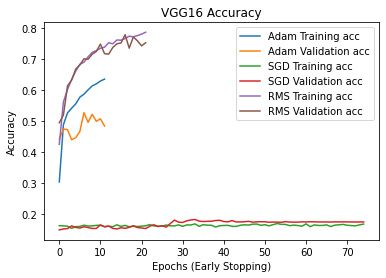

In [ ]:

History =0
History = History2
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']

epochs = range(len(acc))
plt.xlabel('Epochs (Early Stopping)')
plt.ylabel('Accuracy')
plt.title('VGG16 Accuracy')

plt.plot(epochs, acc, label='Adam Training acc')
plt.plot(epochs, val_acc, label='Adam Validation acc')

History =0
History = History4
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, label='SGD Training acc')
plt.plot(epochs, val_acc, label='SGD Validation acc')



History =0
History = History7
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, label='RMS Training acc')
plt.plot(epochs, val_acc, label='RMS Validation acc')
plt.legend()
plt.savefig("Results/DataAugVGG16Historyacc.png")


<h2> Plotting Training and Validation losses of different optimizers </h2>

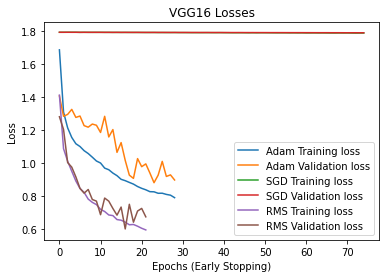

In [ ]:

History =0
History = History3
loss = History.history['loss']
val_loss = History.history['val_loss']

epochs = range(len(loss))
plt.xlabel('Epochs (Early Stopping)')
plt.ylabel('Loss')
plt.title('VGG16 Losses')

plt.plot(epochs, loss, label='Adam Training loss')
plt.plot(epochs, val_loss, label='Adam Validation loss')

History =0
History = History5
loss = History.history['loss']
val_loss = History.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, label='SGD Training loss')
plt.plot(epochs, val_loss, label='SGD Validation loss')



History =0
History = History7
loss = History.history['loss']
val_loss = History.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, label='RMS Training loss')
plt.plot(epochs, val_loss, label='RMS Validation loss')
plt.legend()
plt.savefig("Results/DataAugVGG16Historyloss.png")



<h2> Predict on Unseen Images </h2>


In [23]:
from keras.models import load_model
saved_model = load_model('CheckPoints/VGG-like-Aug-model.h5')
predY = saved_model.predict_generator(test_generator)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


<h2> Confusion Matrix </h2>

In [26]:

predY_classes = predY.argmax(1)
confusion_matrix = pd.crosstab(test_generator.classes, predY_classes,margins=True)
print("Confusion matrix:\n%s" % confusion_matrix)

Confusion matrix:
col_0    0     1     2     3     4     5   All
row_0                                         
0      106   271   218   193   173   183  1144
1      125   283   198   210   169   181  1166
2      113   344   233   226   202   212  1330
3      117   311   229   263   183   194  1297
4      108   272   196   225   149   178  1128
5      131   285   227   213   189   191  1236
All    700  1766  1301  1330  1065  1139  7301


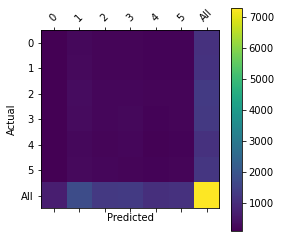

In [27]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.YlOrRd):
  plt.matshow(df_confusion) # imshow
  plt.colorbar()
  tick_marks = np.arange(len(df_confusion.columns))
  plt.xticks(tick_marks, df_confusion.columns, rotation=45)
  plt.yticks(tick_marks, df_confusion.index)
  plt.ylabel("Actual")
  plt.xlabel("Predicted")
  plt.savefig("Results/DataAugVGG16Augconfusion.jpg")
#call function
plot_confusion_matrix(confusion_matrix)